# Squeezing Effect of Negative Gradient (Section 5.3 and Appendix C)
 
- The negative gradient will reliably decrease the confidence of $\bar{y}$, i.e., $\pi_{\theta^{t+1}}(y=\bar{y})$ is guaranteed to decrease.
- The decreased probability mass is ``squeezed'' into the most confident dimension before the update, i.e., $\pi_{\theta^{t+1}}(y=y^*)$, where $y^*=\text{argmax}_{i\in[V]\setminus \lbrace \bar{y} \rbrace} \pi_{\theta^t}(y=i)$ is guaranteed to increase.
- The rich get richer and the poor get poorer: generally, dimensions with high $\pi_{\theta^{t}}$ tend to increase, and those with low $\pi_{\theta^t}$ tend to decrease.
- Peakier $\pi_{\theta^{t}}$ suffer a more serious squeezing effect. If the probability mass concentrates on few dimensions in $\pi_{\theta^{t}}$, which is common for a pretrained model, all $\pi_{\theta^{t+1}}(y\neq y^*)$ decrease (only $y^*$ is considered ``rich'').
- Smaller $\pi_{\theta^{t}}(\bar{y})$ make the squeezing effect stronger. If $\bar{y}$ is unlikely under $\pi_{\theta^{t}}$, the probability mass of all other $\pi_{\theta^{t+1}}(y\neq y^*)$ will be more seriously decreased, and the $\pi_{\theta^{t+1}}(y=y^*)$ increases more. That is what we observed in the off-policy DPO scenario.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import os
import torch

In [42]:
np.random.seed(10086)

def get_W_K(y_k, X, lr=10):
  W_t = np.random.randn(I,K)
  #X = np.array([[0.8,0.2]]).T

  # for i in range(len(y_k)):
  #   y = np.zeros((K,1))
  #   y[y_k[i]]=1
  #   probs_t = scipy.special.softmax(X.T.dot(W_t)).T
  #   W_t1 = W_t - lr*np.outer((probs_t - y), X).T
  #   W_t = W_t1

  y = np.zeros((K,1))
  for i in range(len(y_k)):
    y[y_k[i]]=1
  probs_t = scipy.special.softmax(X.T.dot(W_t)).T
  W_t1 = W_t - lr*np.outer((probs_t - y), X).T
  return W_t1

def label_smoothing(y, r=0.9):
  return np.ones_like(y)*(1-r)/y.shape[0] + y*r

K = 50
I = 4
LR = 1
X = np.random.randn(I,1) #np.array([[0.8,0.2]]).T
Wt_uniform = np.random.randn(I,K)
Wt_flat = np.ones((I,K)) + np.random.randn(I,K)*0.05
Wt_peaky = get_W_K([5, 6, 7, 8, 9, 10, 11, 12], X, 1)


In [43]:
def case_all(W_t, X, plus=42,  plus_lr=0, minus=21, minus_lr=0):
    logits = X.T.dot(W_t)
    y = np.zeros((K,1))
    y[minus]=1
    y = label_smoothing(y, 1)
    
    y2 = np.zeros((K,1))
    y2[plus]=1
    y2 = label_smoothing(y2, 1)
    
    probs_t = scipy.special.softmax(X.T.dot(W_t)).T
    W_t1 = W_t + minus_lr*np.outer((probs_t*1 - y), X).T - plus_lr*np.outer((probs_t - y2), X).T
    probs_t1 = scipy.special.softmax(X.T.dot(W_t1)).T
    # print('----------Logits--------')
    # print(X.T.dot(W_t1))
    return probs_t.squeeze(), probs_t1.squeeze()

def case_all_onebyone(W_t, X, plus=42,  plus_lr=0, minus=21, minus_lr=0):
    logits = X.T.dot(W_t)
    y = np.zeros((K,1))
    y[minus]=1
    y = label_smoothing(y, 1)
    
    y2 = np.zeros((K,1))
    y2[plus]=1
    y2 = label_smoothing(y2, 1)
    
    probs_t = scipy.special.softmax(X.T.dot(W_t)).T
    W_t1 = W_t + minus_lr*np.outer((probs_t*1 - y), X).T - plus_lr*np.outer((probs_t - y2), X).T
    probs_t1 = scipy.special.softmax(X.T.dot(W_t1)).T
    # print('----------Logits--------')
    # print(X.T.dot(W_t1))
    return probs_t.squeeze(), probs_t1.squeeze()

def case_largeV(minus_lr=0.5):
    X = np.random.randn(50,1)
    Wt_uniform = np.random.randn(50,1000)*0.5
    
    logits = X.T.dot(Wt_uniform)
    y = np.zeros((1000,1))
    y[100]=1
    y = label_smoothing(y, 1)
    
    probs_t = scipy.special.softmax(X.T.dot(Wt_uniform)).T
    W_t1 = Wt_uniform + minus_lr*np.outer((probs_t*1 - y), X).T
    probs_t1 = scipy.special.softmax(X.T.dot(W_t1)).T
    return probs_t.squeeze(), probs_t1.squeeze()

In [70]:
Aprobs_t, Aprobs_t1 = case_all(W_t=Wt_uniform, X=X, plus=21, plus_lr=0.5)
Bprobs_t, Bprobs_t1 = case_all(W_t=Wt_flat, X=X, minus=42, minus_lr=0.3)
Cprobs_t, Cprobs_t1 = case_all(W_t=Wt_peaky, X=X, minus=11, minus_lr=0.5)
#Dprobs_t, Dprobs_t1 = case_all(W_t=Wt_peaky, X=X, minus=42, minus_lr=0.5)
Dprobs_t, Dprobs_t1 = case_all(W_t=Wt_peaky, X=X, minus=42, minus_lr=0.5, plus=25, plus_lr=0.5)
Eprobs_t, Eprobs_t1 = case_largeV(minus_lr=1)

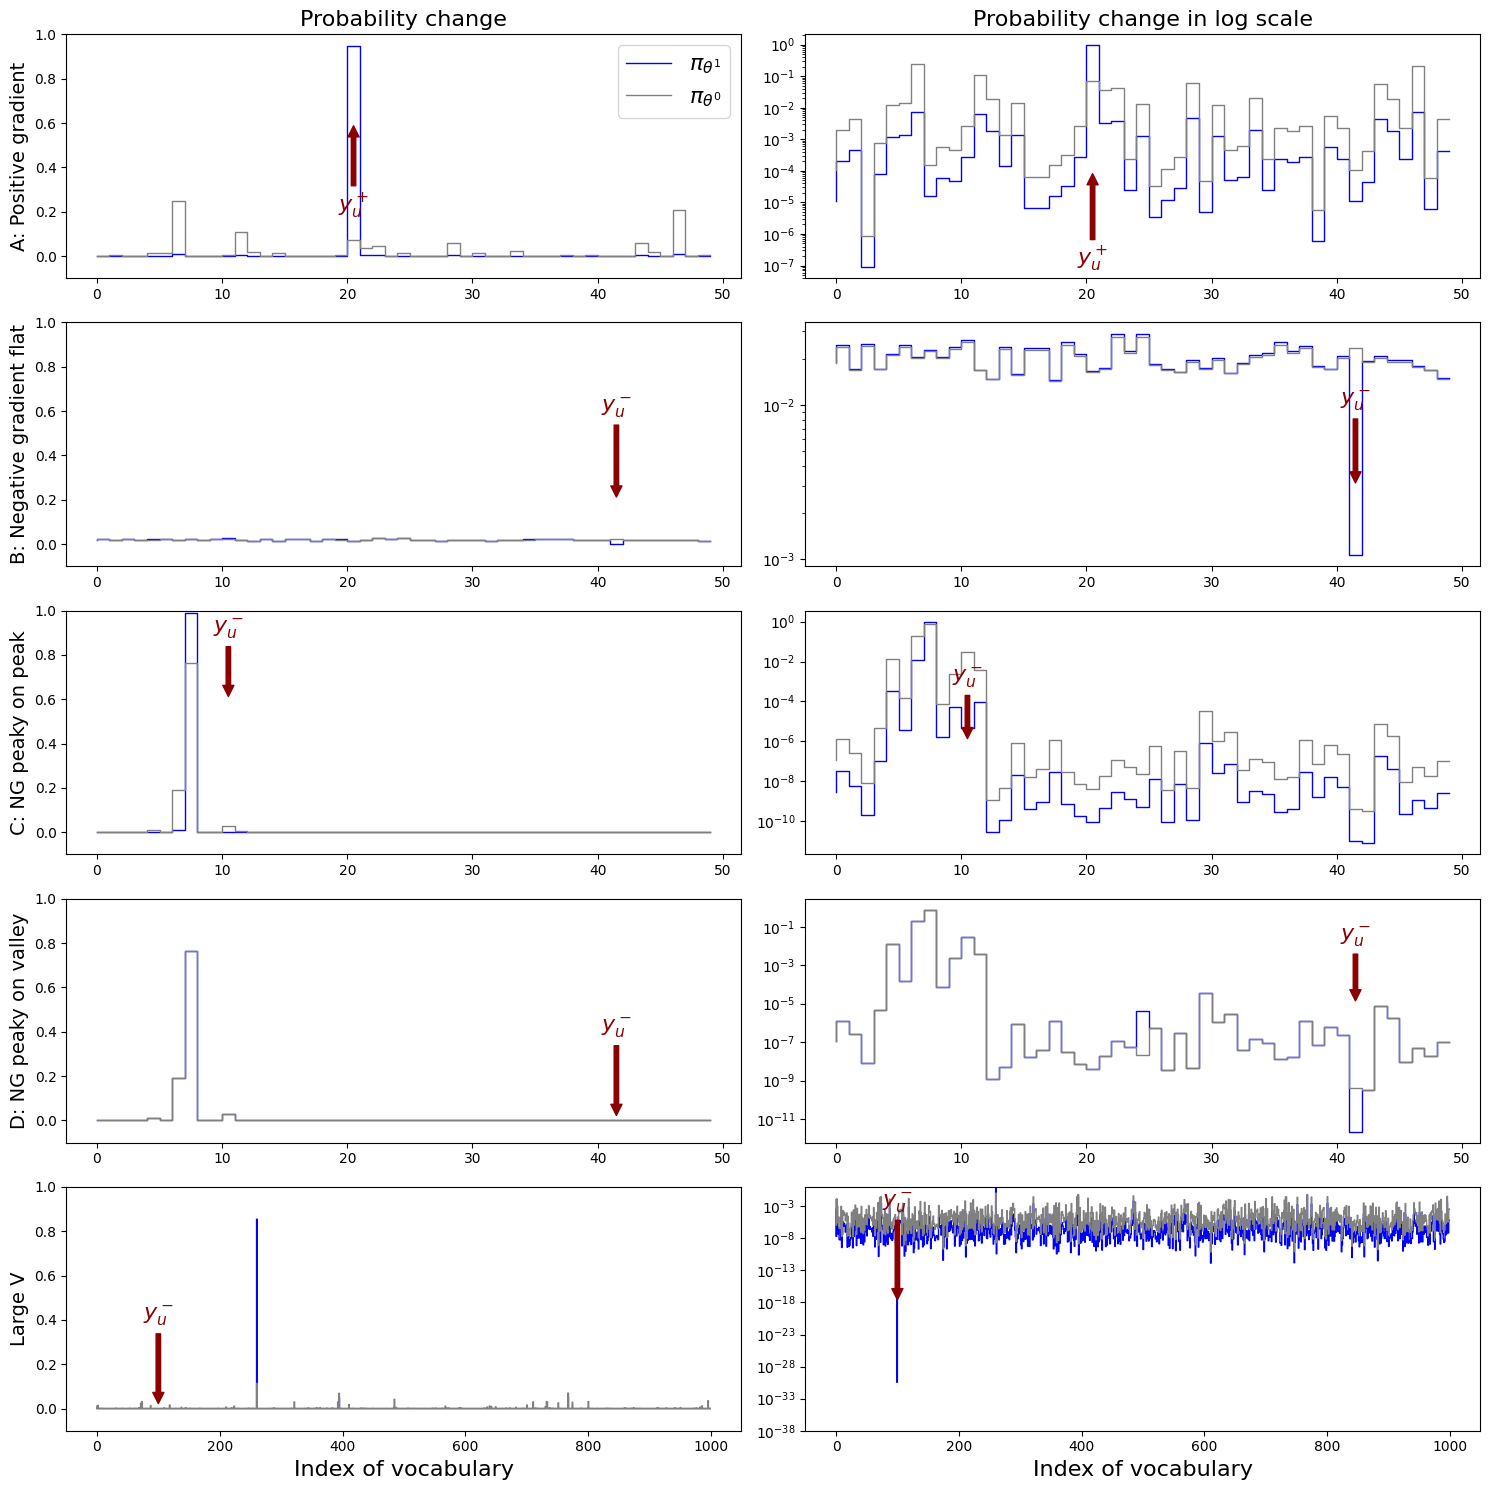

In [71]:
f, ax = plt.subplots(5, 2, figsize=(15,15))
x_axis = np.arange(0,K)
LABEL_LIST = ['A: Positive gradient', 'B: Negative gradient flat', 'C: NG peaky on peak', 'D: NG peaky on valley', 'Large V']
probst_list = [Aprobs_t, Bprobs_t, Cprobs_t, Dprobs_t, Eprobs_t]
probst1_list = [Aprobs_t1, Bprobs_t1, Cprobs_t1, Dprobs_t1, Eprobs_t1]
ARROW_X   = [(20.5, 0.6), (41.5, 0.2), (10.5, 0.6), (41.5, 0.01), (100, 0.01)]
ARROW_XT  = [(20.5, 0.2), (41.5, 0.6), (10.5, 0.9), (41.5, 0.4), (100, 0.4)]
ARROWL_X  = [(20.5, 1e-4),(41.5, 3e-3),(10.5, 1e-6),(41.5, 1e-5),(100, 1e-18)]
ARROWL_XT = [(20.5, 1e-7),(41.5, 1e-2),(10.5, 1e-3),(41.5, 2e-2),(100, 1e-3)]
ARROW_TEXT = [r"$y_u^+$", r"$y_u^-$", r"$y_u^-$", r"$y_u^-$", r"$y_u^-$"]
for i in range(5):
    if i == 4:
        x_axis = np.arange(0,1000)
    ax[i][0].step(x_axis, probst1_list[i], label=r'$\pi_{\theta^1}$',alpha=1, linewidth=1,color='blue')
    ax[i][0].step(x_axis, probst_list[i], label=r'$\pi_{\theta^0}$',alpha=1, linewidth=1,color='grey')
    ax[i][0].annotate(ARROW_TEXT[i], xy=ARROW_X[i], xytext=ARROW_XT[i], arrowprops=dict(arrowstyle="simple",color='darkred',),
                      horizontalalignment='center',color='darkred',fontsize=16)
    ax[i][0].set_ylim(-0.1,1) 
    ax[i][0].set_ylabel(LABEL_LIST[i], fontsize=14)

    ax[i][1].step(x_axis, probst1_list[i], label=r'$\pi_{\theta^1}$',alpha=1, linewidth=1,color='blue')
    ax[i][1].step(x_axis, probst_list[i], label=r'$\pi_{\theta^0}$',alpha=1, linewidth=1,color='grey')
    ax[i][1].annotate(ARROW_TEXT[i], xy=ARROWL_X[i], xytext=ARROWL_XT[i], arrowprops=dict(arrowstyle="simple",color='darkred',),
                      horizontalalignment='center',color='darkred',fontsize=16)
    ax[i][1].set_yscale('log')

    if i == 0:
        ax[i][0].set_title('Probability change', fontsize=16)
        ax[i][1].set_title('Probability change in log scale', fontsize=16)


ax[0][0].legend(fontsize=16)
ax[4][0].set_xlabel('Index of vocabulary', fontsize=16)
ax[4][1].set_xlabel('Index of vocabulary', fontsize=16)
ax[4][1].set_ylim(1e-38,1.1)
plt.tight_layout()

PATH = "E://P5_5_SFT_dynamics//results_visualize//exp_results"
#save_name = os.path.join('figures','squeeze_effect_exp.pdf')
#plt.savefig(save_name)

# Learning Dynamics of MNIST and LeNet (Figure 1)

In [1]:
import numpy as np
from tqdm import tqdm
import copy
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as T
import torch.utils.data as Data 
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

In [11]:
FIGSIZE = 28
EPOCHS = 100
HID_SIZE = 128
K_CLAS = 10
X_DIM = FIGSIZE*FIGSIZE
LR = 1e-3
train_transform = T.Compose([T.Resize(FIGSIZE),T.ToTensor()])
rnd_perm = np.random.permutation(np.arange(0,60000))
full_trainset = torchvision.datasets.MNIST('data',train=True, download=True, transform=train_transform)
train_subset = torch.utils.data.Subset(full_trainset, list(rnd_perm[:2000]))
test_subset = torch.utils.data.Subset(full_trainset, list(rnd_perm[2000:4000]))

seed_loader = torch.utils.data.DataLoader(train_subset, batch_size=2000, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=2000, shuffle=False)

In [22]:
for X, Y in seed_loader:
    break
seed_x = np.zeros((100, 1, FIGSIZE, FIGSIZE))
seed_y = np.zeros((100,1))
for i in range(10):
    mask = y==i
    for j in range(10):
        idx = i*10+j
        seed_x[idx,:] = X[mask][j]
        seed_y[idx] = i

In [41]:
class MLP_B1(nn.Module):
  def __init__(self, in_dim=X_DIM, hid_size=HID_SIZE):
    super(MLP_B1, self).__init__()
    self.in_dim = in_dim
    self.hid_size = hid_size
    self.Alice = nn.Sequential(
              nn.Linear(self.in_dim, self.hid_size),
              nn.ReLU(True),
              nn.Linear(self.hid_size, self.hid_size),
              nn.ReLU(True),
              nn.Linear(self.hid_size, self.hid_size),
              nn.ReLU(True),
              nn.Linear(self.hid_size, self.hid_size),
              nn.ReLU(True),
            )
    self.Bob = nn.Sequential(
              nn.Linear(self.hid_size, K_CLAS)
            )

  def forward(self, x):
    z = self.Alice(x)
    hid = self.Bob(z)
    return z, hid
      
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            
            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5
            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=60),
            nn.Tanh(),
            nn.Linear(in_features=60, out_features=42),
            nn.Tanh(),
        )
        self.Bob = nn.Sequential(
                nn.Linear(in_features=42, out_features=10),
        )
        
    def forward(self, x):
        z = self.classifier(self.feature(x))
        out = self.Bob(z)
        return out,z

def get_ld_metrics(model, model_delay, x, cos=False):
    def _get_adapt_mean(a, a_dly, cos):
        if cos:
            cos_sim = torch.nn.CosineSimilarity(dim=1,eps=1e-6)
            return torch.mean(cos_sim(a_dly, (a-a_dly))).detach().cpu()
        else:
            return torch.mean(torch.diag(torch.mm(a_dly, (a-a_dly).T))).detach().cpu()
    p, z = model(x)
    p_dly, z_dly = model_delay(x)
    z_adapt = _get_adapt_mean(z, z_dly, cos)
    p_adapt = _get_adapt_mean(p, p_dly, cos)
    return z_adapt, p_adapt

In [42]:
model = LeNet() #MLP_B1()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

In [43]:
results = {'train_loss':[],'test_loss':[], 'test_acc':[], 'z_adapt':[], 'p_adapt':[], 'z_adapt_cos':[], 'p_adapt_cos':[],}
cnt = 0
track_gap = 50
for g in tqdm(range(EPOCHS)):
  model.train(True)
  for data_iter_step, (x, y) in enumerate(train_loader):
    cnt += 1
    model.train()
    if cnt%track_gap==1:
        model_delay = copy.deepcopy(model)
    #x, y = x.float().reshape(-1,FIGSIZE*FIGSIZE).cuda(), y.long().cuda()
    x, y = x.float().cuda(), y.long().cuda()
    outputs, z = model(x)
    loss = nn.CrossEntropyLoss()(outputs, y)
    optimizer.zero_grad()   
    loss.backward()
    optimizer.step()
    results['train_loss'].append(loss.item())
    # ----------- Track adaptations
    if cnt%track_gap==1:
        z_adapt, p_adapt = get_ld_metrics(model, model_delay, x, cos=False)
        results['z_adapt'].append(z_adapt)
        results['p_adapt'].append(p_adapt)      
        z_adapt, p_adapt = get_ld_metrics(model, model_delay, x, cos=True)
        results['z_adapt_cos'].append(z_adapt)
        results['p_adapt_cos'].append(p_adapt)          

    # --------- Evaluation for test loss
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        for data_iter_step, (x, y) in enumerate(test_loader):
            x, y = x.float().cuda(), y.long().cuda()
            outputs, z = model(x)
            loss = nn.CrossEntropyLoss()(outputs, y)
            test_loss += loss.item()
            test_acc += (outputs.argmax(dim=1) == y).sum().item()
        
        results['test_loss'].append(test_loss)
        test_acc /= 2000
        results['test_acc'].append(test_acc)    
    
  scheduler.step()


  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'p cos')

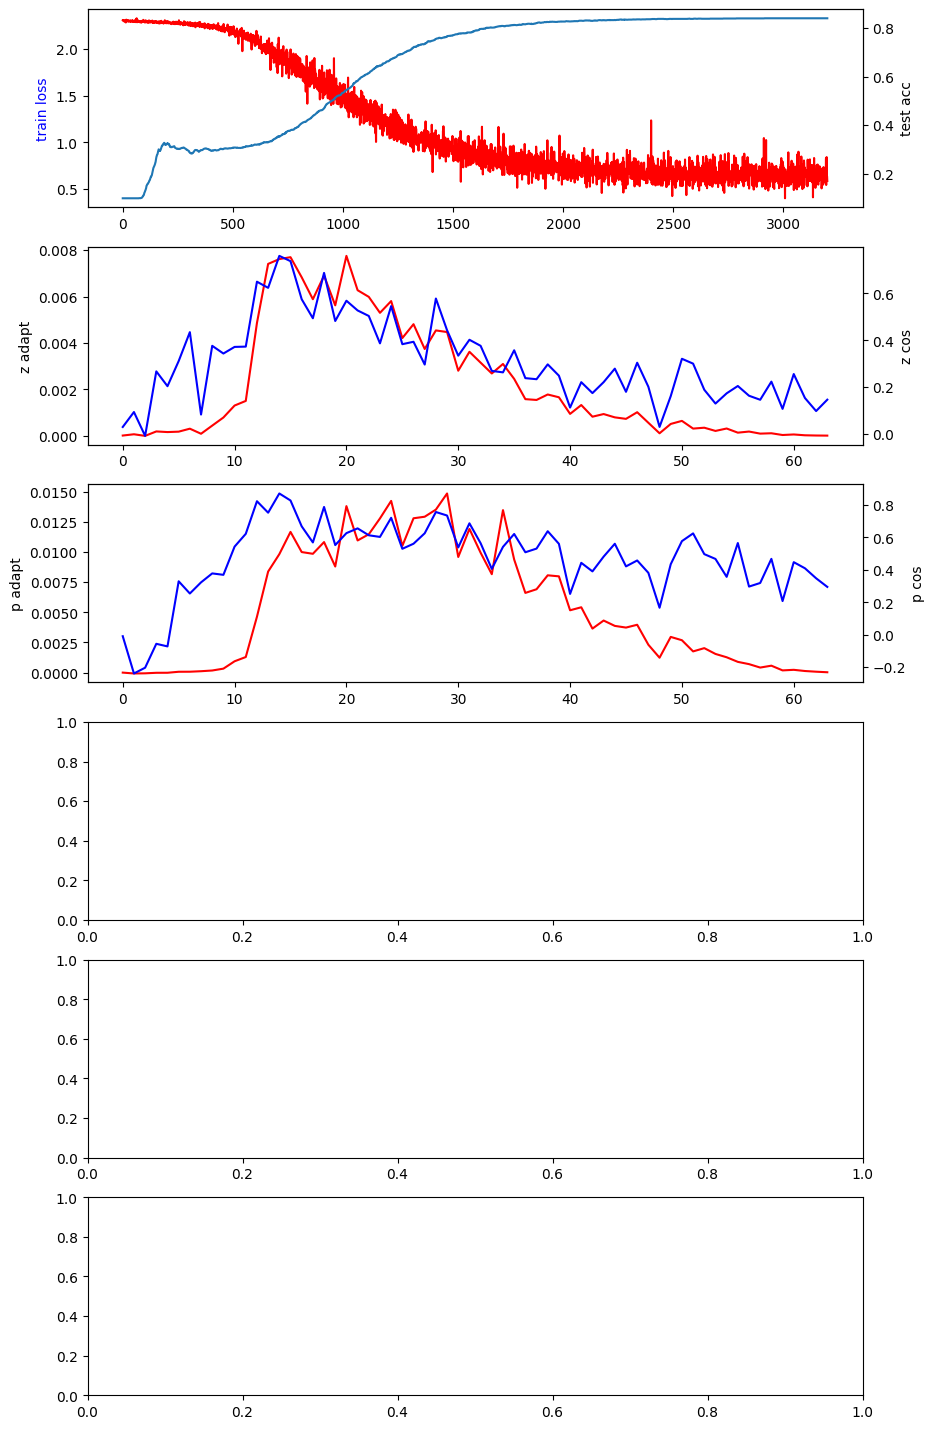

In [55]:
fig, ax = plt.subplots(6,1,figsize=(10,18))

ax[0].plot(results['train_loss'],color='red')
ax[0].set_ylabel('train loss',color='blue')
ax00 = ax[0].twinx()
ax00.plot(results['test_acc'])
ax00.set_ylabel('test acc')

ax[1].plot(results['z_adapt'],label='z_dot',color='red')
ax[1].set_ylabel('z adapt')
ax11=ax[1].twinx()
ax11.plot(results['z_adapt_cos'],label='z_cos',color='blue')
ax11.set_ylabel('z cos')


ax[2].plot(results['p_adapt'],label='p_dot',color='red')
ax[2].set_ylabel('p adapt')
ax22=ax[2].twinx()
ax22.plot(results['p_adapt_cos'],label='p_cos',color='blue')
ax22.set_ylabel('p cos')

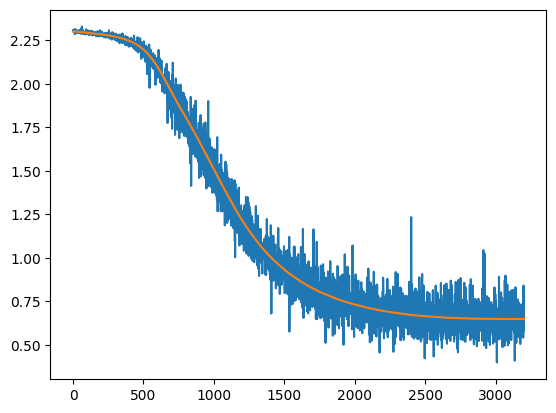

In [44]:
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])

In [12]:
eval_loader = torch.utils.data.DataLoader(
                    torchvision.datasets.MNIST('data',train=False, download=True, transform=train_transform),
                    batch_size=10000,shuffle=False)

In [13]:
with torch.no_grad():
    for data_iter_step, (x, y) in enumerate(eval_loader):
        x, y = x.float().cuda(), y.long().cuda()
        _, pred_log_all = model(x)

In [14]:
prob_all = nn.Softmax(-1)(pred_log_all).detach().cpu()

In [15]:
pred_classes = []
hm_results = np.zeros((10,10))
for k in range(10):
    mask = y.cpu()==k
    pred_classes.append(prob_all[mask].mean(0))
    hm_results[k,:] = prob_all[mask].mean(0)

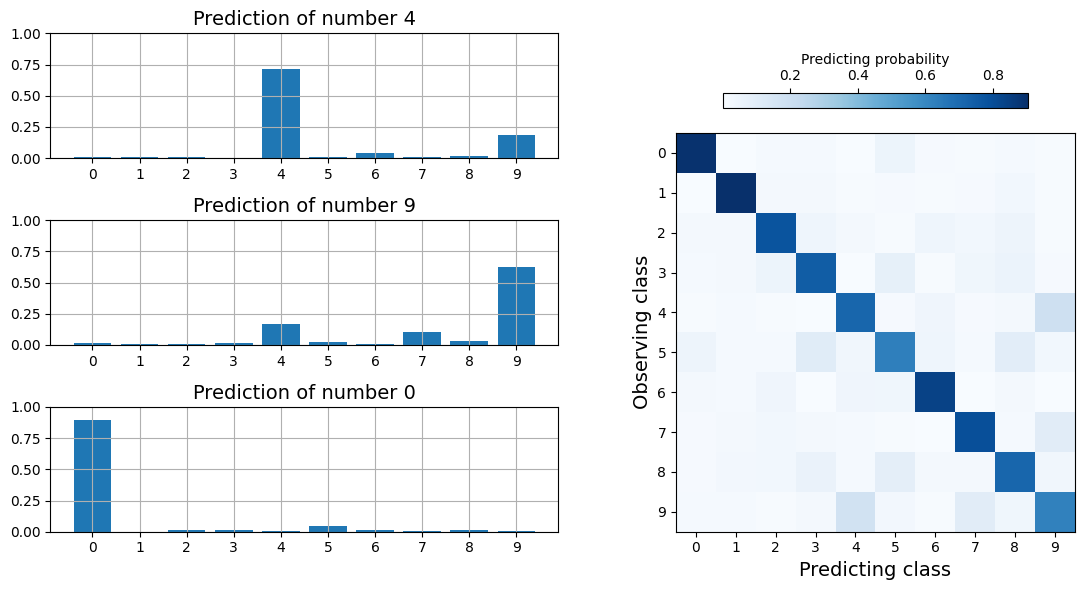

In [75]:
fig, ax = plt.subplot_mosaic("BA;CA;DA",figsize=(12,6),gridspec_kw={'width_ratios': [1, 1.2]})
x_axis = np.arange(0,10)

ax['B'].bar(x_axis, pred_classes[4])
ax['B'].set_title("Prediction of number 4",fontsize=14)
ax['B'].set_ylim(0,1)
ax['B'].grid(True)
ax['B'].set_xticks([0,1,2,3,4,5,6,7,8,9])

ax['C'].bar(x_axis, pred_classes[9])
ax['C'].set_title("Prediction of number 9",fontsize=14)
ax['C'].set_ylim(0,1)
ax['C'].grid(True)
ax['C'].set_xticks([0,1,2,3,4,5,6,7,8,9])

ax['D'].bar(x_axis, pred_classes[0])
ax['D'].set_title("Prediction of number 0",fontsize=14)
ax['D'].set_ylim(0,1)
ax['D'].grid(True)
ax['D'].set_xticks([0,1,2,3,4,5,6,7,8,9])

im = ax['A'].imshow(hm_results, cmap='Blues', interpolation='nearest')
cbar = ax['A'].figure.colorbar(im, ax=ax['A'], location='top', label='Predicting probability',shrink=0.5)
ax['A'].set_xticks([0,1,2,3,4,5,6,7,8,9])
ax['A'].set_ylabel('Observing class', fontsize=14)
ax['A'].set_xlabel('Predicting class', fontsize=14)
ax['A'].set_yticks([0,1,2,3,4,5,6,7,8,9])
ax['A'].grid(which="minor", color="w", linestyle='-', linewidth=3)

plt.tight_layout()

PATH = "E://P5_5_SFT_dynamics//results_visualize//exp_results"
save_name = os.path.join('figures','mnist_exp.pdf')
#plt.savefig(save_name)